数据基本信息:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2013-01-31 to 2023-07-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   humidity  126 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB

缺失值统计:
humidity    1
dtype: int64


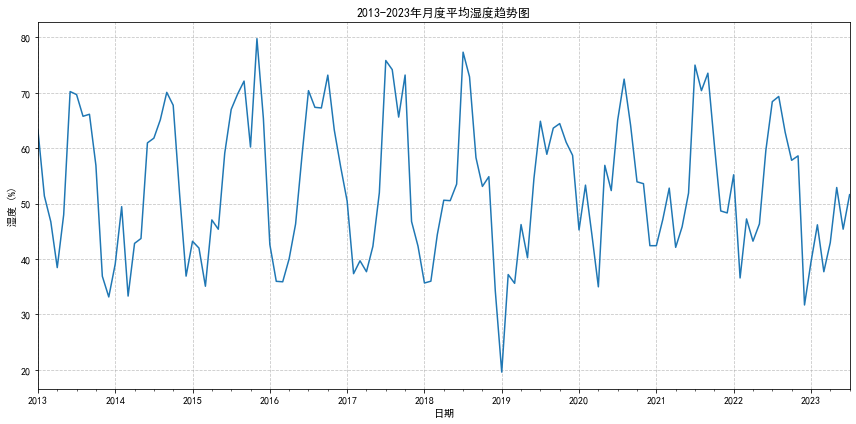

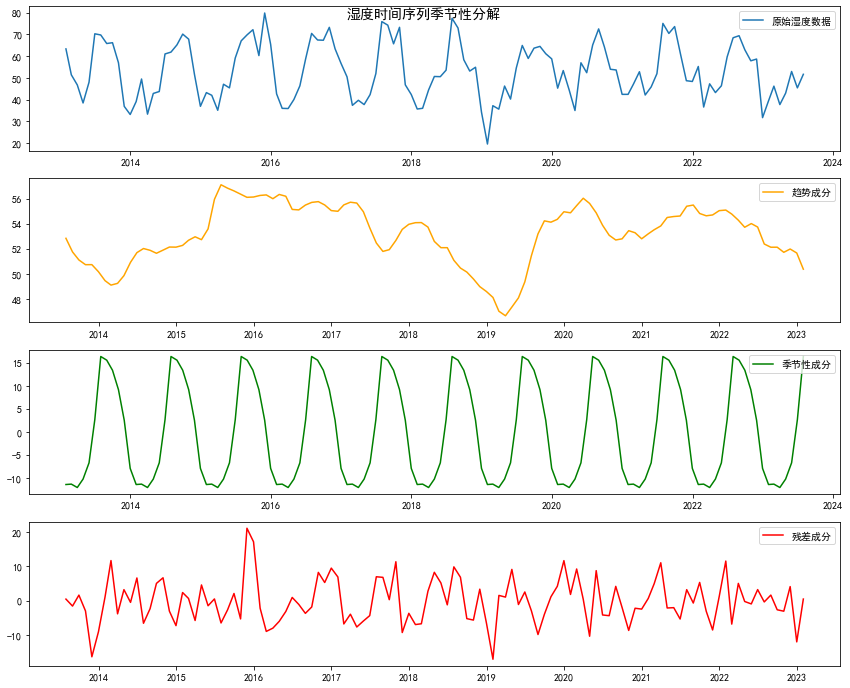


测试集RMSE: 6.63%


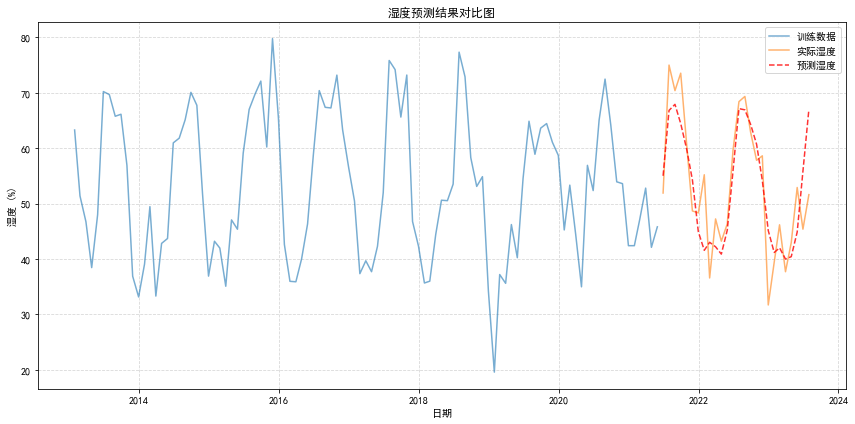

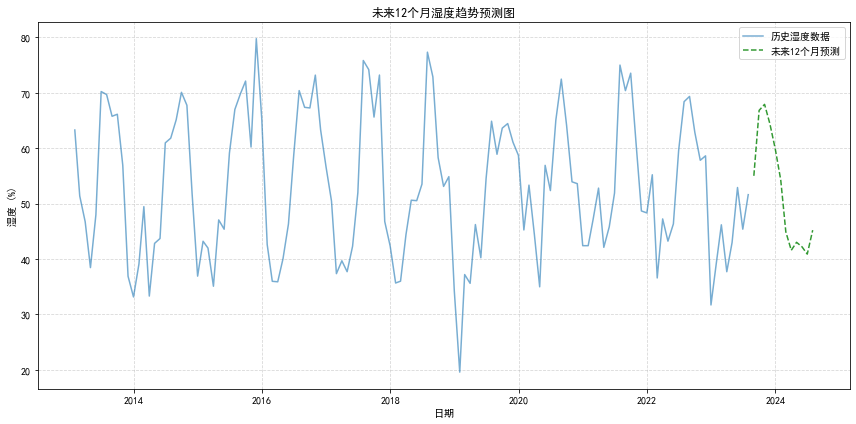


✅ 未来12个月湿度预测结果已保存至：C:\Users\PC\Desktop\湿度预测结果\未来12个月湿度预测结果.csv
✅ 模型评估报告已保存至：C:\Users\PC\Desktop\湿度预测结果\模型评估报告.txt


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
import os
warnings.filterwarnings('ignore')

# 设置中文显示（确保图表中文标题正常显示）
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei"]  # 支持中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 创建指定的保存目录（如果不存在）
output_dir = r"C:\Users\PC\Desktop\湿度预测结果"
os.makedirs(output_dir, exist_ok=True)

# 读取湿度数据（确保文件路径正确）
df = pd.read_csv(r"C:\Users\PC\Desktop\数据驱动清洗后数据\2013-2023monthly_avg_humidity.csv")

# 转换日期格式
df['date'] = pd.to_datetime(df['date'])

# 湿度列——数值类型
df['humidity'] = pd.to_numeric(df['humidity'])

# 设置日期为索引
df.set_index('date', inplace=True)

# 数据探索
print("数据基本信息:")
df.info()

# 检查缺失值
print("\n缺失值统计:")
print(df.isnull().sum())

# 填充缺失值（如果有，这里用前向填充）
df['humidity'].fillna(method='ffill', inplace=True)

# ====================== 图表 1：月度平均湿度趋势 ======================
plt.figure(figsize=(12, 6))
df['humidity'].plot(title='2013-2023年月度平均湿度趋势图')
plt.xlabel('日期')
plt.ylabel('湿度 (%)')
plt.grid(True, linestyle='--', alpha=0.7)  # 添加网格线
plt.tight_layout()  # 优化布局
plt.savefig(os.path.join(output_dir, '1_月度平均湿度趋势图.png'))
plt.show()

# ====================== 图表 2：湿度季节性分解 ======================
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['humidity'], model='additive', period=12)
trend, seasonal, residual = decomposition.trend, decomposition.seasonal, decomposition.resid

plt.figure(figsize=(12, 10))
plt.suptitle('湿度时间序列季节性分解', y=0.95, fontsize=14)  # 添加总标题

plt.subplot(411)
plt.plot(df['humidity'], label='原始湿度数据')
plt.legend()

plt.subplot(412)
plt.plot(trend, label='趋势成分', color='orange')
plt.legend()

plt.subplot(413)
plt.plot(seasonal, label='季节性成分', color='green')
plt.legend()

plt.subplot(414)
plt.plot(residual, label='残差成分', color='red')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '2_湿度季节性分解图.png'))
plt.show()

# ====================== 划分训练集和测试集 ======================
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# ====================== ARIMA模型训练与预测 ======================
model = ARIMA(train['humidity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

# 预测测试集
predictions = model_fit.forecast(steps=len(test))
predictions.index = test.index

# 计算RMSE
rmse = np.sqrt(mean_squared_error(test['humidity'], predictions))
print(f'\n测试集RMSE: {rmse:.2f}%')

# ====================== 图表 3：预测结果对比 ======================
plt.figure(figsize=(12, 6))
plt.plot(train['humidity'], label='训练数据', alpha=0.6)
plt.plot(test['humidity'], label='实际湿度', alpha=0.6)
plt.plot(predictions, label='预测湿度', color='red', linestyle='--', alpha=0.8)

plt.title('湿度预测结果对比图')
plt.xlabel('日期')
plt.ylabel('湿度 (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '3_湿度预测结果对比图.png'))
plt.show()

# ====================== 图表 4：未来12个月湿度预测 ======================
future_predictions = model_fit.forecast(steps=12)
future_dates = pd.date_range(start=df.index[-1], periods=13, freq='MS')[1:]  # 生成未来12个月日期
future_predictions.index = future_dates

plt.figure(figsize=(12, 6))
plt.plot(df['humidity'], label='历史湿度数据', alpha=0.6)
plt.plot(future_predictions, label='未来12个月预测', color='green', linestyle='--', alpha=0.8)

plt.title('未来12个月湿度趋势预测图')
plt.xlabel('日期')
plt.ylabel('湿度 (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '4_未来湿度预测趋势图.png'))
plt.show()

# ====================== 保存预测结果 ======================
save_path = os.path.join(output_dir, '未来12个月湿度预测结果.csv')
future_df = pd.DataFrame({
    'date': future_dates.strftime('%Y-%m'),  # 格式化为年月
    'predicted_humidity': future_predictions.round(2)  # 保留2位小数
})
future_df.to_csv(save_path, index=False, encoding='utf-8-sig')
print(f"\n✅ 未来12个月湿度预测结果已保存至：{save_path}")

# ====================== 保存模型评估报告 ======================
report_path = os.path.join(output_dir, '模型评估报告.txt')
with open(report_path, 'w', encoding='utf-8') as f:
    f.write("==================== 湿度预测模型评估报告 ====================\n\n")
    f.write(f"数据时间范围：{df.index.min().strftime('%Y-%m')} 至 {df.index.max().strftime('%Y-%m')}\n")
    f.write(f"训练集样本量：{len(train)}  |  测试集样本量：{len(test)}\n\n")
    f.write(f"ARIMA模型参数：order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)\n\n")
    f.write(f"测试集RMSE（均方根误差）：{rmse:.2f}%\n")
    f.write("（注：RMSE越小，模型预测精度越高）\n")

print(f"✅ 模型评估报告已保存至：{report_path}")